In [3]:
import numpy as np
from astroquery.mast import Catalogs
#from astroquery.mast import Tesscut
from astroquery.mast import Observations
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
#import pandas as pd
from scipy import signal



In [4]:
1326.903983+2457000.0

2458326.903983

In [5]:
#Insert TIC ID and BJD
tic_id = '141914082'
bjd = 2458341.89227
sector = '1'
cadence= '1800'
tbjd = bjd - 2457000.00


def dload_url (tic_id, sector): #Dowloads URL through query for general 2-minute cadence data given TIC ID and Sector
    
    obsTable = Observations.query_criteria(
        obs_collection = "TESS",
        dataproduct_type = ["TIMESERIES"], productType = 'LIGHTCURVE',
        target_name = tic_id,
        sequence_number=sector)
    products = Observations.get_product_list(obsTable)
    manifest = Observations.download_products(products, extension = ['fits'])
    return manifest

def gen_url(tic_id, sector, cadence, version): #Generates URL for TASOC data given TIC ID, Sector, Cadence, and Version
    tic_id_1 = tic_id.zfill(16)
    tic_id_2 = tic_id.zfill(11)
    if (cadence == '1800'):
        sub_dir = "ffi"
    else: 
        sub_dir = "tpf"
    cadence = cadence.zfill(4)
    
    url = "http://archive.stsci.edu/hlsps/tasoc/s000" + str(sector) + "/" + sub_dir + "/" \
            + tic_id_1[0:4] + "/" + tic_id_1[4:8] + "/" + tic_id_1[8:12] + "/" + tic_id_1[12:16] + "/"\
            + "hlsp_tasoc_tess_" + sub_dir + "_tic" + tic_id_2 + "-s0" + str(sector) + "-c" + cadence + "_tess_"\
            + version + "_lc.fits"
    return url

In [6]:
if (cadence == '1800'):
    fits_lc = gen_url(tic_id, sector, cadence, 'v04')
    fits.info(fits_lc)
    fits.getdata(fits_lc, ext=1)
    
    with fits.open(fits_lc, mode="readonly") as hdulist:
        tess_bjds = hdulist[1].data['TIME']
        sap_fluxes = hdulist[1].data['FLUX_RAW']#SIWTCH
        pdcsap_fluxes = hdulist[1].data['FLUX_BKG']
    
else:
    manifest = dload_url(tic_id, sector)
    print(manifest)
    fits_lc = manifest[0][0]
    fits.info(fits_lc)
    fits.getdata(fits_lc, ext=1)
    with fits.open(fits_lc, mode="readonly") as hdulist:
        tess_bjds = hdulist[1].data['TIME']
        sap_fluxes = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

Filename: /Users/jshabazz/.astropy/cache/download/py3/fdec061cdf83c6f2700910bb5821e334
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   ()      
  1  LIGHTCURVE    1 BinTableHDU     88   1282R x 14C   [D, E, J, D, D, D, D, D, J, J, D, D, D, D]   
  2  SUMIMAGE      1 ImageHDU        87   (15, 15)   float64   
  3  APERTURE      1 ImageHDU        87   (15, 15)   int32   


In [7]:
#manifest = dload_url(tic_id, sector)
#fits_lc = manifest[0][0]
#fits_lc = gen_url(tic_id, sector, '1800', 'v04')
#fits.info(fits_lc)
#fits.getdata(fits_lc, ext=1)

In [8]:
#Stores HDU data into variables for plotting
#with fits.open(fits_lc, mode="readonly") as hdulist:
#    tess_bjds = hdulist[1].data['TIME']
#   sap_fluxes = hdulist[1].data['FLUX_RAW']
#    pdcsap_fluxes = hdulist[1].data['FLUX_RAW']

In [24]:
#FILTER SETTINGS
if (cadence == '1800' ):
    med_flux_1 = signal.medfilt(sap_fluxes, kernel_size=65)
else:
    med_flux_1 = signal.medfilt(pdcsap_fluxes, kernel_size=101)
print(med_flux_1)

[59270.8515625  59281.23046875 59299.5703125  ... 60162.19140625
 60154.7578125  60112.65234375]


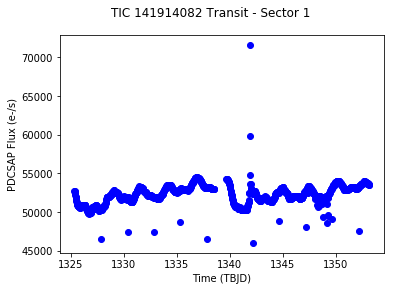

In [30]:
#PLOT LIGHT CURVE

t0 = tbjd #transit time

fig, ax = plt.subplots()

#ax.plot(tess_bjds, pdcsap_fluxes, 'ko')#BKG black


ax.plot(tess_bjds, (sap_fluxes-pdcsap_fluxes), 'bo')#RAW blue
#ax.plot(tess_bjds, med_flux_1, 'k-')


#ax.set_xlim(t0-3.0, t0+3.0)
#ax.set_xlim(1344,1350)


#ax.axvline(x=t0, color = 'red')

fig.suptitle("TIC " + str(tic_id) + " Transit - Sector " + str(sector))
ax.set_ylabel("PDCSAP Flux (e-/s)")
ax.set_xlabel("Time (TBJD)")

plt.subplots_adjust(left=0.15)
plt.show()

In [31]:
pdcpeak_ind = signal.find_peaks(sap_fluxes, threshold = 100 )
print(pdcpeak_ind)

(array([ 741, 1025, 1061, 1084, 1092]), {'left_thresholds': array([17860.80078125,   184.25390625,   107.796875  ,   142.07421875,
         265.08203125]), 'right_thresholds': array([11782.1171875 ,   116.77734375,   101.2890625 ,   415.58984375,
         222.84765625])})


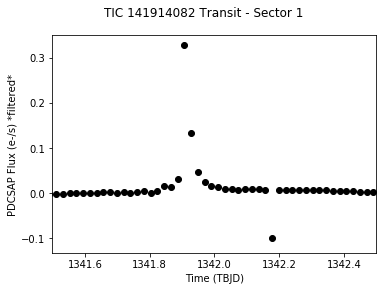

In [35]:
detrend_lc = (sap_fluxes/med_flux_1) - 1


fig, ax = plt.subplots()

ax.plot(tess_bjds, detrend_lc, 'ko')


ax.set_xlim(1341.5,1342.5)

fig.suptitle("TIC " + str(tic_id) + " Transit - Sector " + str(sector))
ax.set_ylabel("PDCSAP Flux (e-/s) *filtered*")
ax.set_xlabel("Time (TBJD)")

plt.subplots_adjust(left=0.15)
plt.show()

In [313]:
#Possibly use quality flags to get rid of outliers that arent flares, NaN

In [314]:
#outliers=[]
def detect_outlier(data_1):
    
    threshold=69
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [315]:
outlier_datapoints = detect_outlier(pdcpeak_ind)
print(outlier_datapoints)

TypeError: unsupported operand type(s) for +: 'int' and 'dict'